In [0]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 # 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.5MB/s 


## **Importing files to get Text, brand,colour and Image**

In [0]:
from google.colab import files
from google.colab import drive
import json
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#https://stackoverflow.com/questions/49206488/accessing-pickle-file-in-google-colab
import pickle
#drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Asgn/Apparel"
infile = open(DATA_PATH+'/16k_apperal_data_preprocessed','rb')
data = pickle.load(infile)

In [0]:
data.head(15)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95
60,B014ICB9A0,FNC7C,Black,https://images-na.ssl-images-amazon.com/images...,APPAREL,supernatural chibis sam dean castiel neck shir...,$7.39
78,B011YPK0MW,Feel The Piece,Navy,https://images-na.ssl-images-amazon.com/images...,SHIRT,feel piece sami dip dye top one size navy,$72.40
95,B0079QXJ3S,FineBrandShop,Fuchsia,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies fuchsia pink seamless stone set tube top,$7.50
107,B00R7DO9ZA,Finejo,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,finejo ladies sleeveless shirt lace shirts hig...,$11.99
121,B011JQWCCM,Ferrari,Red,https://images-na.ssl-images-amazon.com/images...,SHIRT,puma womens ferrari big shield tee rosso corsa...,$34.99


In [0]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [0]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [0]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#https://stackoverflow.com/questions/49206488/accessing-pickle-file-in-google-colab
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Asgn/Apparel"
infile = open(DATA_PATH+'/word2vec_model','rb')
model = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [0]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [0]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [0]:
doc_id = 0
w2v_title = []
#w2v_title['column_name'].astype(str)
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [0]:
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

In [0]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [0]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

Using TensorFlow backend.


In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [0]:
DATA_PATH = "/content/drive/My Drive/Asgn/Apparel"
#bottleneck_features_train = np.load('16k_data_cnn_features.npy')
bottleneck_features_train = np.load(open(DATA_PATH+'/16k_data_cnn_features.npy','rb'))
asins = np.load(open(DATA_PATH+'/16k_data_cnn_feature_asins.npy', 'rb'))
asins = list(asins)
infile = open(DATA_PATH+'/16k_apperal_data_preprocessed','rb')
data = pickle.load(infile)
df_asins = list(data['asin'])

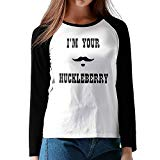

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 8.231806347680503e-11


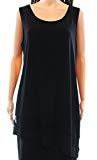

ASIN : B071S2VKT5
Product Title:  alfani deep womens large tunic mesh asymmetric blouse black l 
Brand : J.Crew
Product title: j crew factory sheer dotted split neck blouse 
Product Type : SWEATER
Euclidean Distance : 0.1414213562373095


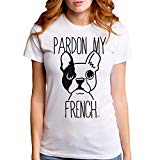

ASIN : B01J6M8C48
Product Title:  pardon french shortsleeve womens crew tee 
Brand : J.Crew
Product title: j crew denim vest calyer wash 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


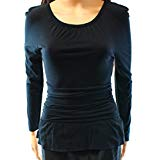

ASIN : B06X1CKXFM
Product Title:  marc marc jacobs womens ruched scoop neck blouse black xs 
Brand : J.Crew
Product title: jcrew perfect shirt foil dot navy 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


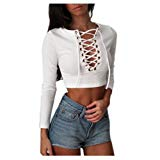

ASIN : B01LW7OWOX
Product Title:  toogoor women spring autumn sexy lace short tops tshirt neck long sleeve bandage cropped short tshirtswhitesus4uk8 
Brand : J.Crew
Product title: j crew collection purple jeweled silk tank top sample one kind size 2 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


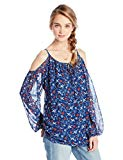

ASIN : B01E13D2GU
Product Title:  ella moon womens solana long sleeve tie neck cold shoulder blouse navy plumier medium 
Brand : J.Crew
Product title: play comme des garcons j crew big heart shirt size 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


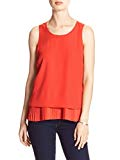

ASIN : B01GYC3W2U
Product Title:  banana republic womens pleatedunderlay tank valliant poppy red small 
Brand : J.Crew
Product title: j crew play comme des garcons gold heart tshirt size style e3054 white new 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


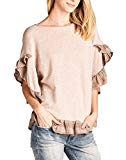

ASIN : B01LZDRMJ6
Product Title:  oddi womens short sleeve ruffle top taupe cotton shirts small 
Brand : J.Crew
Product title: jcrew petite collarless buttonup shirt indigo 10 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


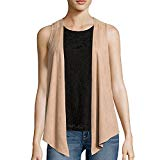

ASIN : B01MAT31YT
Product Title:  self esteem layeredlook tank top suede vest size 
Brand : J.Crew
Product title: j crew vneck bandsleeve shell 
Product Type : SHIRT
Euclidean Distance : 0.1414213562373095


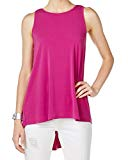

ASIN : B01GTF67UG
Product Title:  vince camuto womens small asymmetrical hem blouse pink 
Brand : J.Crew
Product title: j crew liberty pajama top wiltshire floral size xss style 26440 def 
Product Type : SHIRT
Euclidean Distance : 0.1732050807568877


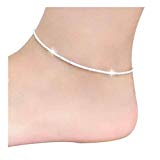

ASIN : B073VVS6DN
Product Title:  efaster women hemp rope chain ankle bracelet barefoot sandal beach foot jewelry 
Brand : J.Crew
Product title: j crew womens layered drapey silk hem tank top blouse dusty begonia small 
Product Type : SHIRT
Euclidean Distance : 0.1732050807568877


In [0]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

def get_similar_products_cnn(doc_id, weit, wbrnd, wclr, wimg, nr):
    doc_id = asins.index(df_asins[doc_id])
    
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist = (weit * idf_w2v_dist +  wbrnd * brand_dist + wclr * color_dist + wimg * bottleneck_features_dist)/float(weit + wbrnd + wclr + wimg)

    indices = np.argsort(pairwise_dist.flatten())[0:nr]
    df_indices = list(data.index[indices])
    pdists  = np.sort(pairwise_dist.flatten())[0:nr]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('ASIN :',data['asin'].loc[df_indices[i]])
            print('Product Title: ', row['title'])
            print('Brand :',data['brand'].loc[df_indices[i]])
            print('Product title:',data['title'].loc[df_indices[i]])
            print('Product Type :',data['product_type_name'].loc[df_indices[i]])
            print('Euclidean Distance :', pdists[i])
           

get_similar_products_cnn(12562,50,30,20,100,11)

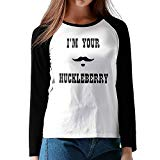

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 5.3108428049551636e-11


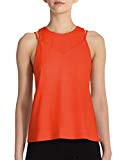

ASIN : B0741BMD7S
Product Title:  alexander wang orange illusion layer tank top 4 
Brand : Fylo
Product title: fylo womens size large lightweight blouse ivory 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


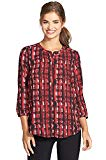

ASIN : B017VEE8H8
Product Title:  nydj womens henley blouse plus size red pleated back2x 
Brand : KAIA
Product title: agnes orinda womens plus size zebra print asymmetric hem scoop neck top ivory 1x 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


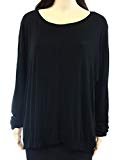

ASIN : B071LFJ1DN
Product Title:  h bordeaux womens plus dolman sleeve ribbed knit top black 1x 
Brand : Soprano
Product title: soprano plus size sleeveless swing tank top size 2x 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


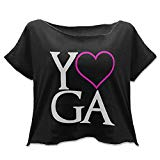

ASIN : B00M7DFH9C
Product Title:  mamisari love yoga crop top womens workout running active shirt tshirt tee 
Brand : TUXE
Product title: tuxe rookie bodysuit b1421ixs 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


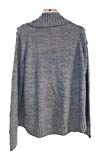

ASIN : B01CE40WRA
Product Title:  mossimo womens high neck long sleeve tunic medium blue 
Brand : Marolaya
Product title: marolaya womens feather print caftan poncho tunic sexy tassel beach cover 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


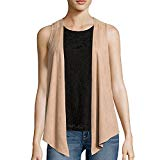

ASIN : B01MAT31YT
Product Title:  self esteem layeredlook tank top suede vest size 
Brand : J.Crew
Product title: j crew vneck bandsleeve shell 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


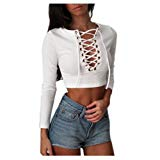

ASIN : B01LW7OWOX
Product Title:  toogoor women spring autumn sexy lace short tops tshirt neck long sleeve bandage cropped short tshirtswhitesus4uk8 
Brand : J.Crew
Product title: j crew collection purple jeweled silk tank top sample one kind size 2 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


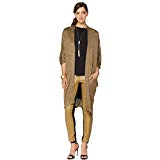

ASIN : B072JZD68D
Product Title:  nene nene leakes kimonostyle cardigan 476048 antique moss 
Brand : Grace
Product title: grace womens royal ivory blouse 34 sleeve flow large 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


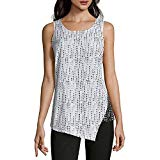

ASIN : B00LVRCNLU
Product Title:  worthington layered woven tank top petite size pxl 
Brand : P.J. Salvage
Product title: pj salvage womens army top rarmls2 ivory large 
Product Type : SLEEPWEAR
Euclidean Distance : 0.13685937700384793


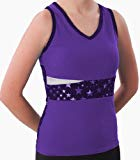

ASIN : B071FYSXJJ
Product Title:  pizzazz performance wear 5700ss pur yl 5700ss youth superstar panel top keyhole  purple  youth large 
Brand : ARAZA
Product title: araza women button sheer shirt plus size 2x white long tab sleeves collar neck pockets 
Product Type : SHIRT
Euclidean Distance : 0.13685937700384793


In [0]:
get_similar_products_cnn(12562,50,30,30,200,11)

### **DIfferent combination of Weights to each feature**

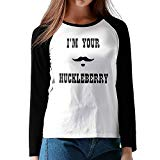

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 3.7631114732253734e-11


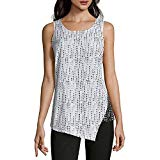

ASIN : B00LVRCNLU
Product Title:  worthington layered woven tank top petite size pxl 
Brand : P.J. Salvage
Product title: pj salvage womens army top rarmls2 ivory large 
Product Type : SLEEPWEAR
Euclidean Distance : 0.12121830534626529


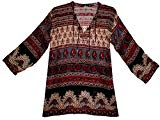

ASIN : B01N55I9ZR
Product Title:  foi indian vintage cotton top women ehs hippie blusa dress ethnic blouse 
Brand : XOXO
Product title: xoxo womens ls wrap front cardigan ivory small 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


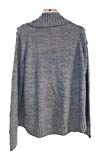

ASIN : B01CE40WRA
Product Title:  mossimo womens high neck long sleeve tunic medium blue 
Brand : Marolaya
Product title: marolaya womens feather print caftan poncho tunic sexy tassel beach cover 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


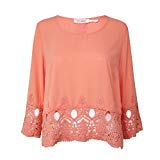

ASIN : B0733R2CJK
Product Title:  blu pepper womens crochet 34 length sleeve top orange medium 
Brand : BLVD
Product title: blvd womens graphic tshirt l 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


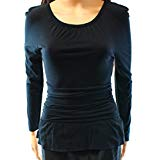

ASIN : B06X1CKXFM
Product Title:  marc marc jacobs womens ruched scoop neck blouse black xs 
Brand : J.Crew
Product title: jcrew perfect shirt foil dot navy 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


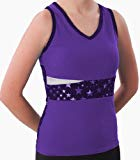

ASIN : B071FYSXJJ
Product Title:  pizzazz performance wear 5700ss pur yl 5700ss youth superstar panel top keyhole  purple  youth large 
Brand : ARAZA
Product title: araza women button sheer shirt plus size 2x white long tab sleeves collar neck pockets 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


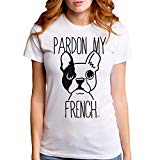

ASIN : B01J6M8C48
Product Title:  pardon french shortsleeve womens crew tee 
Brand : J.Crew
Product title: j crew denim vest calyer wash 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


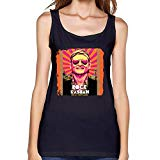

ASIN : B01N6IOOLE
Product Title:  futhure womens rock kasbah neck diy tank top 
Brand : Cleobella
Product title: cleobella mila top ivory xs 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


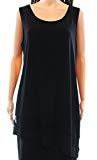

ASIN : B071S2VKT5
Product Title:  alfani deep womens large tunic mesh asymmetric blouse black l 
Brand : J.Crew
Product title: j crew factory sheer dotted split neck blouse 
Product Type : SWEATER
Euclidean Distance : 0.12121830534626529


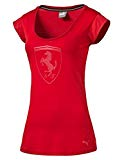

ASIN : B0755DS1V6
Product Title:  puma womens ferrari big shield tee rosso corsa tshirt xl 
Brand : WAYF
Product title: wayf ivory ditzy gwen shoulder top medium 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


In [0]:
get_similar_products_cnn(12562,40,30,30,250,11)

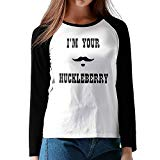

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 3.2927225390722017e-11


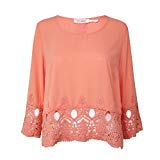

ASIN : B0733R2CJK
Product Title:  blu pepper womens crochet 34 length sleeve top orange medium 
Brand : BLVD
Product title: blvd womens graphic tshirt l 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


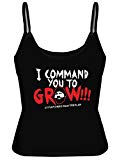

ASIN : B01N2QX096
Product Title:  fellt diy print custom ct fletcher womens sexy top 
Brand : Nell
Product title: nell womens langley top 0 white 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


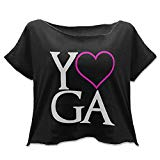

ASIN : B00M7DFH9C
Product Title:  mamisari love yoga crop top womens workout running active shirt tshirt tee 
Brand : TUXE
Product title: tuxe rookie bodysuit b1421ixs 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


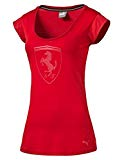

ASIN : B0755DS1V6
Product Title:  puma womens ferrari big shield tee rosso corsa tshirt xl 
Brand : WAYF
Product title: wayf ivory ditzy gwen shoulder top medium 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


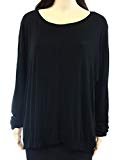

ASIN : B071LFJ1DN
Product Title:  h bordeaux womens plus dolman sleeve ribbed knit top black 1x 
Brand : Soprano
Product title: soprano plus size sleeveless swing tank top size 2x 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


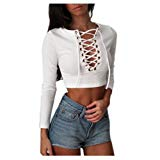

ASIN : B01LW7OWOX
Product Title:  toogoor women spring autumn sexy lace short tops tshirt neck long sleeve bandage cropped short tshirtswhitesus4uk8 
Brand : J.Crew
Product title: j crew collection purple jeweled silk tank top sample one kind size 2 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


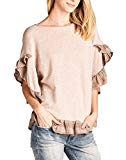

ASIN : B01LZDRMJ6
Product Title:  oddi womens short sleeve ruffle top taupe cotton shirts small 
Brand : J.Crew
Product title: jcrew petite collarless buttonup shirt indigo 10 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


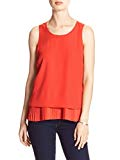

ASIN : B01GYC3W2U
Product Title:  banana republic womens pleatedunderlay tank valliant poppy red small 
Brand : J.Crew
Product title: j crew play comme des garcons gold heart tshirt size style e3054 white new 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


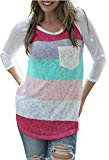

ASIN : B074JK4QJ8
Product Title:  acquaa womens long sleeve stripe pocket fashion tshirt picture 
Brand : Fylo
Product title: fylo dress casual career shirts women variety styles small ivory 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


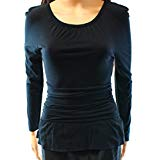

ASIN : B06X1CKXFM
Product Title:  marc marc jacobs womens ruched scoop neck blouse black xs 
Brand : J.Crew
Product title: jcrew perfect shirt foil dot navy 
Product Type : SHIRT
Euclidean Distance : 0.10606601717798213


In [0]:
get_similar_products_cnn(12562,40,30,30,300,11)

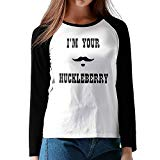

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 2.582527481625256e-11


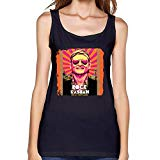

ASIN : B01N6IOOLE
Product Title:  futhure womens rock kasbah neck diy tank top 
Brand : Cleobella
Product title: cleobella mila top ivory xs 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


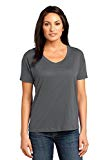

ASIN : B00MEVED3S
Product Title:  district made womens modal blend relaxed v neck tee warm grey 
Brand : Yoco
Product title: yoco womens crochet tiewaist top chiffon sleeves one size ivory 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


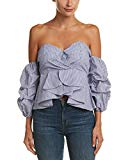

ASIN : B0746553XF
Product Title:  haute rogue womens offtheshoulder top blue 
Brand : DSQUARED2
Product title: dsquared2 womens ivory 100 silk sleeveless blouse top us xs 38 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


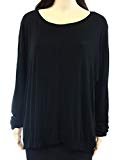

ASIN : B071LFJ1DN
Product Title:  h bordeaux womens plus dolman sleeve ribbed knit top black 1x 
Brand : Soprano
Product title: soprano plus size sleeveless swing tank top size 2x 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


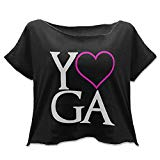

ASIN : B00M7DFH9C
Product Title:  mamisari love yoga crop top womens workout running active shirt tshirt tee 
Brand : TUXE
Product title: tuxe rookie bodysuit b1421ixs 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


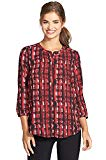

ASIN : B017VEE8H8
Product Title:  nydj womens henley blouse plus size red pleated back2x 
Brand : KAIA
Product title: agnes orinda womens plus size zebra print asymmetric hem scoop neck top ivory 1x 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


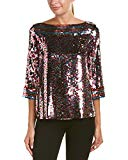

ASIN : B01HDN2QGC
Product Title:  trina turk womens makoa sequin top xs 
Brand : MaxMara
Product title: maxmara womens draped panel silk jersey combo nebula top sz l ivory 160429mm 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


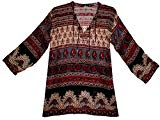

ASIN : B01N55I9ZR
Product Title:  foi indian vintage cotton top women ehs hippie blusa dress ethnic blouse 
Brand : XOXO
Product title: xoxo womens ls wrap front cardigan ivory small 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


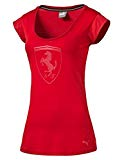

ASIN : B0755DS1V6
Product Title:  puma womens ferrari big shield tee rosso corsa tshirt xl 
Brand : WAYF
Product title: wayf ivory ditzy gwen shoulder top medium 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


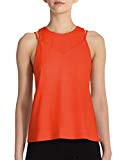

ASIN : B0741BMD7S
Product Title:  alexander wang orange illusion layer tank top 4 
Brand : Fylo
Product title: fylo womens size large lightweight blouse ivory 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


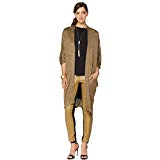

ASIN : B072JZD68D
Product Title:  nene nene leakes kimonostyle cardigan 476048 antique moss 
Brand : Grace
Product title: grace womens royal ivory blouse 34 sleeve flow large 
Product Type : SHIRT
Euclidean Distance : 0.0831890330807703


In [0]:
get_similar_products_cnn(12562,40,30,40,400,12)

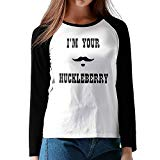

ASIN : B01G376G88
Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Brand : J.Crew
Product title: j crew sheer beaded coverup sz style a0370 ivory new 
Product Type : SHIRT
Euclidean Distance : 1.8815557366126867e-11


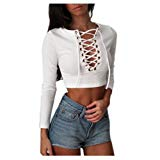

ASIN : B01LW7OWOX
Product Title:  toogoor women spring autumn sexy lace short tops tshirt neck long sleeve bandage cropped short tshirtswhitesus4uk8 
Brand : J.Crew
Product title: j crew collection purple jeweled silk tank top sample one kind size 2 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


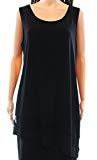

ASIN : B071S2VKT5
Product Title:  alfani deep womens large tunic mesh asymmetric blouse black l 
Brand : J.Crew
Product title: j crew factory sheer dotted split neck blouse 
Product Type : SWEATER
Euclidean Distance : 0.10101525445522108


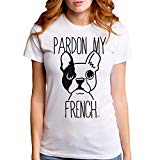

ASIN : B01J6M8C48
Product Title:  pardon french shortsleeve womens crew tee 
Brand : J.Crew
Product title: j crew denim vest calyer wash 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


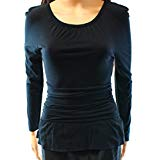

ASIN : B06X1CKXFM
Product Title:  marc marc jacobs womens ruched scoop neck blouse black xs 
Brand : J.Crew
Product title: jcrew perfect shirt foil dot navy 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


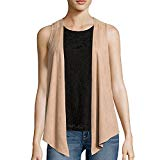

ASIN : B01MAT31YT
Product Title:  self esteem layeredlook tank top suede vest size 
Brand : J.Crew
Product title: j crew vneck bandsleeve shell 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


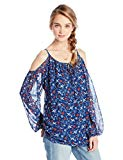

ASIN : B01E13D2GU
Product Title:  ella moon womens solana long sleeve tie neck cold shoulder blouse navy plumier medium 
Brand : J.Crew
Product title: play comme des garcons j crew big heart shirt size 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


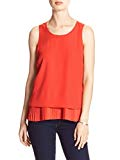

ASIN : B01GYC3W2U
Product Title:  banana republic womens pleatedunderlay tank valliant poppy red small 
Brand : J.Crew
Product title: j crew play comme des garcons gold heart tshirt size style e3054 white new 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


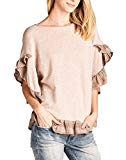

ASIN : B01LZDRMJ6
Product Title:  oddi womens short sleeve ruffle top taupe cotton shirts small 
Brand : J.Crew
Product title: jcrew petite collarless buttonup shirt indigo 10 
Product Type : SHIRT
Euclidean Distance : 0.10101525445522108


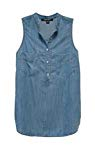

ASIN : B010UKPZHC
Product Title:  fifteen twenty sleeveless denim shirt size medium 
Brand : NioBe
Product title: womens rayon span comfortable 34 sleeve tunic top solid xl ivory 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


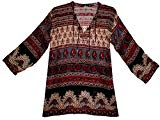

ASIN : B01N55I9ZR
Product Title:  foi indian vintage cotton top women ehs hippie blusa dress ethnic blouse 
Brand : XOXO
Product title: xoxo womens ls wrap front cardigan ivory small 
Product Type : SHIRT
Euclidean Distance : 0.12121830534626529


In [0]:
get_similar_products_cnn(12562,40,60,50,550,11)

## **Observations**
Apparel recommendation tried using text , brand , image and colour. Weights are varied for each feature. Different results are observed with different weights.